# Homework 1 - Due January 25, 2018

*Step 1 - Environment Setup*

Git installed, class repository forked, and Anaconda installed.

# Exploring Datasets

*Step 2 - Datasets*

In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import json
import requests
import datetime as dt
from datetime import datetime
import math
sns.set(style='ticks', palette='Set2')
%matplotlib inline
plt.style.use('seaborn')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


 
  
   
    
     
      
      
# (1) Read in data from Excel
We obtain air quality data obtained from [UCI Air Quality Database](https://archive.ics.uci.edu/ml/datasets/Air+quality). This data is collected from a sensor in an Italian city, and measures numerous types of particles found in the air.  We choose to examine only a few columns of the dataset (Carbon Monoxide, Total Nitrogen Oxides, and Nitrogen Dioxide), but also include temperature and humidity measures to better understand patterns in the data. Time-dependent patterns in the data should help us identify human impacts on air quality, as well as time and weather effects.

Chemicals are measured in micrograms per cubic meter, temperature in degrees Centigrade, and relative and absolute humidity in percentage points.

Below, we read in the data and drop unwanted variables. We also drop the first 6 periods of data and the last 14 periods of data, so our time period contains only full days (from midnight to midnight).

In [2]:
data1 = pd.read_excel('AirQualityUCI.xlsx')
data1 = pd.DataFrame(data1, columns = ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 
                                    'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 
                                    'PT08.S5(O3)', 'T', 'RH', 'AH'])

data1 = data1.drop(['PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)'], 1)

data1 = data1.drop(data1.index[[0, 1, 2, 3, 4, 5, 9342, 9343, 9344, 9345, 9346, 9347, 9348, 9349, 9350, 9351, 9352, 9353, 9354, 9355, 9356]])

In [3]:
data1.head()

,Date,Time,CO(GT),NOx(GT),NO2(GT),T,RH,AH
6,2004-03-11,00:00:00,1.2,62.0,77.0,11.325,56.775000,0.760312
7,2004-03-11,01:00:00,1.0,62.0,76.0,10.675,60.000000,0.770238
8,2004-03-11,02:00:00,0.9,45.0,60.0,10.650,59.674999,0.764819
9,2004-03-11,03:00:00,0.6,-200.0,-200.0,10.250,60.200001,0.751657
10,2004-03-11,04:00:00,-200.0,21.0,34.0,10.075,60.474999,0.746495


We see that our data has been read in correctly, at least in terms of organization. We will congtinue to examine missing values. We do not have detailed information regarding the sensor itself, and why certain measurments are missing for given hours.  However, we still have thousands of observations for each variable of interest, meaning that we have sufficient information to still understand the data.

Missing values are denoted with -200, so we will examine the columns containing them and replace them with a missing value:

In [4]:
print((data1 == -200).sum())

Date          0
Time          0
CO(GT)     1682
NOx(GT)    1639
NO2(GT)    1642
T           366
RH          366
AH          366
dtype: int64


In [5]:
data1 = data1.replace(-200, np.NaN)

In [6]:
print((data1 == -200).sum())

Date       0
Time       0
CO(GT)     0
NOx(GT)    0
NO2(GT)    0
T          0
RH         0
AH         0
dtype: int64


Here are summary statistics for the cleaned data:

In [7]:
data1.describe()

,CO(GT),NOx(GT),NO2(GT),T,RH,AH
count,7654.000000,7697.000000,7694.000000,8970.000000,8970.000000,8970.000000
mean,2.153031,246.938898,113.061736,18.322521,49.239351,1.026207
std,1.453772,213.064733,48.357945,8.837076,17.318114,0.404023
min,0.100000,2.000000,2.000000,-1.900000,9.175000,0.184679
25%,1.100000,98.000000,78.000000,11.800000,35.806251,0.736725
50%,1.800000,180.000000,109.000000,17.750000,49.525000,0.996459
75%,2.900000,326.000000,141.875000,24.400000,62.518751,1.314114
max,11.900000,1479.000000,339.700000,44.600000,88.725000,2.231036


We note that certain columns appear to have significant outliers. For example, NOx(GT) has a max of 1479 micrograms per cubic meter, while its median is only 180. We will now use violin plots to visualize the distribution of these measurements, using two plots due to scaling issues (as CO has a lower concentration).

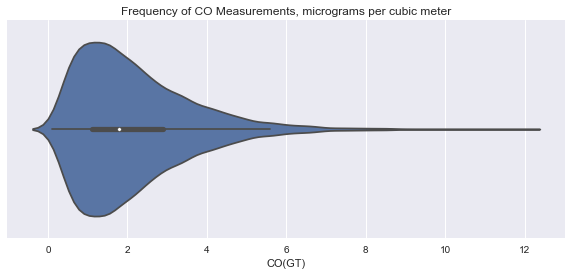

In [8]:
f, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Frequency of CO Measurements, micrograms per cubic meter")
sns.violinplot(data1['CO(GT)'], ax = ax)
plt.show()

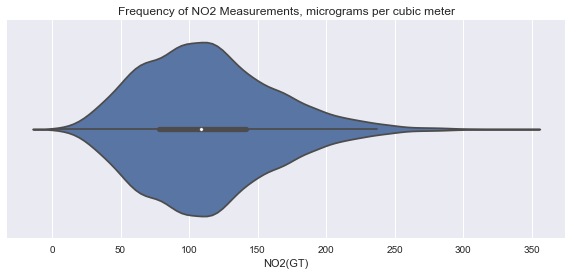

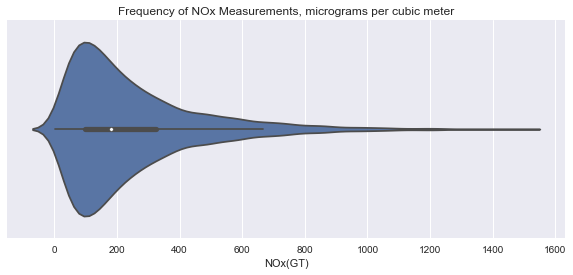

In [9]:
f, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Frequency of NO2 Measurements, micrograms per cubic meter")
sns.violinplot(data1['NO2(GT)'])
plt.show()
f, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Frequency of NOx Measurements, micrograms per cubic meter")
sns.violinplot(data1['NOx(GT)'])
plt.show()

Little is known regarding the reason for such extreme outliers, especially for NOx. We see that, despite the extreme skewness toward the left of this distribution, a fair number of observations reach levels exceeding 1000, and conclude that certain periods were in reality marked by unusual levels of NOx.

Before plotting, we fill in missing values for CO with the sample median.  This will decrease the variance, but it has the advantage of approximating true daily trends.  Due to the distributions noted above, this will likely lead to a better fit with the data than the mean (with the imputed values reflecting the actual values, given the mean will be skewed upward by the outliers as previously discussed), although peak hours may not have as high concentration as they normally should.  We propose that this method of controlling for missing data will allow us to see trends, although the specific data may not be perfectly indicative of the true yearly levels.

In [10]:
data1['CO(GT)'] = data1['CO(GT)'].fillna(data1['CO(GT)'].median())

Below, we show the peak periods of corrected CO levels (correction as explained above):

Text(0.5,1,'Yearly CO Readings, Accumulated By Hour')

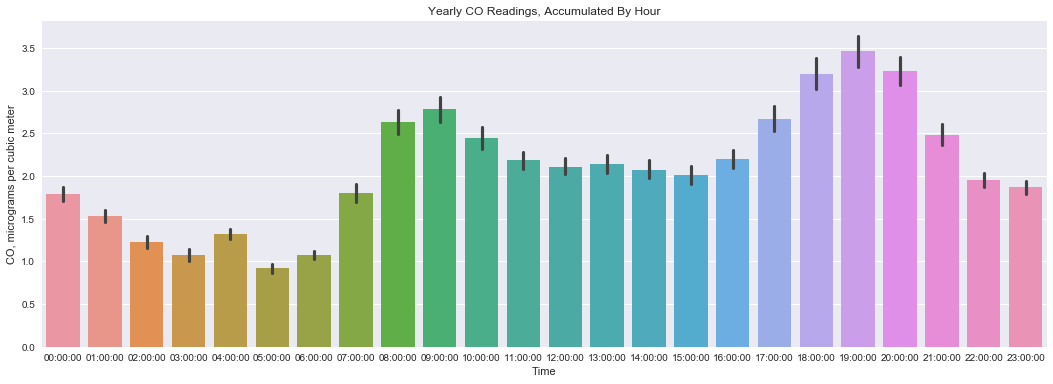

In [11]:
f, ax = plt.subplots(figsize = (18, 6))
sns.barplot(x = data1['Time'], y = data1['CO(GT)'], ax = ax)
ax.set_ylabel("CO, micrograms per cubic meter")
ax.set_title("Yearly CO Readings, Accumulated By Hour")

We note that peaks occur around 8am and 8 pm, with heightened levels during the day.  This makes sense, as the city's citizens would likely be more active during the day, with greater light and energy consumption in the morning and night.  It appears that, if the primary driver of these trends is human activity, the chemical content of the air disperses rather quickly, as it reaches a low point around 6am. (These bars reflect aggregate levels for the whole year at a given time, and are not to be viewed as daily measurements or averages).

Finally, we show a few correlations between variables, beginning with a correlation table:

In [12]:
data1.corr()

,CO(GT),NOx(GT),NO2(GT),T,RH,AH
CO(GT),1.000000,0.788379,0.669102,0.006778,0.042930,0.024890
NOx(GT),0.788379,1.000000,0.763086,-0.270791,0.222285,-0.149566
NO2(GT),0.669102,0.763086,1.000000,-0.188022,-0.090206,-0.334991
T,0.006778,-0.270791,-0.188022,1.000000,-0.578175,0.657106
RH,0.042930,0.222285,-0.090206,-0.578175,1.000000,0.167603
AH,0.024890,-0.149566,-0.334991,0.657106,0.167603,1.000000


The gases in question all vary together, though with different levels of correlation. CO varies positively with temperature and humidity, although only slightly, while the other gases exhibit a slightly greater negative correlation with these measures of weather. We note above, as below, that temperature and humidity have an inverse relationship; taken together with the correlations between climate variables and the gas measurements, there may be a climate-based mechanism deciding the approximate levels of each gas concentration in the air that day.

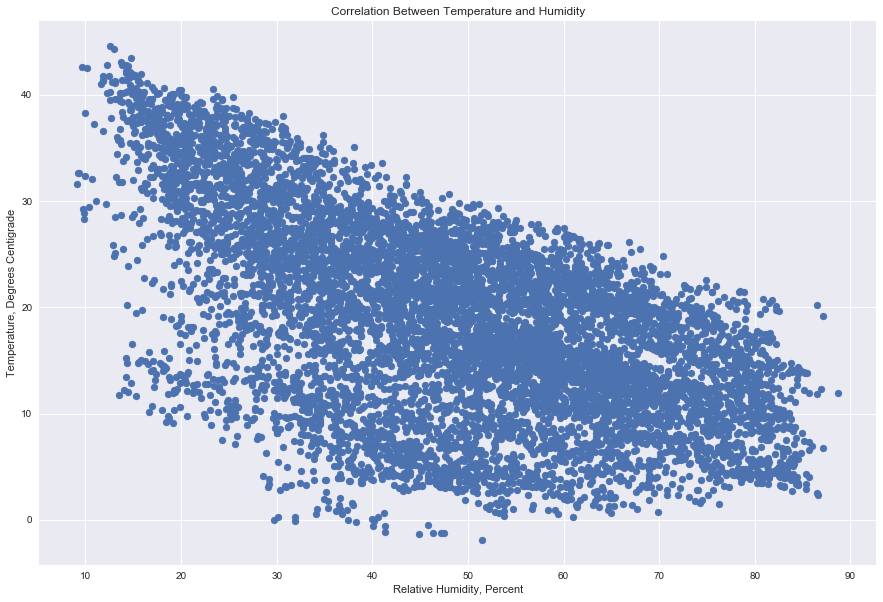

In [13]:
f, ax = plt.subplots(figsize = (15, 10))
plt.scatter(x = data1['RH'], y = data1['T'])
ax.set_ylabel("Temperature, Degrees Centigrade")
ax.set_xlabel("Relative Humidity, Percent")
ax.set_title("Correlation Between Temperature and Humidity")
plt.show()

Finally, as we see below, lower temperatures correspond to the more extreme values of NOx. This may parallel with the inversion experienced during the winter along the Wasatch Front, in Utah, where low temperatures are associated with poor visibility and air quality.

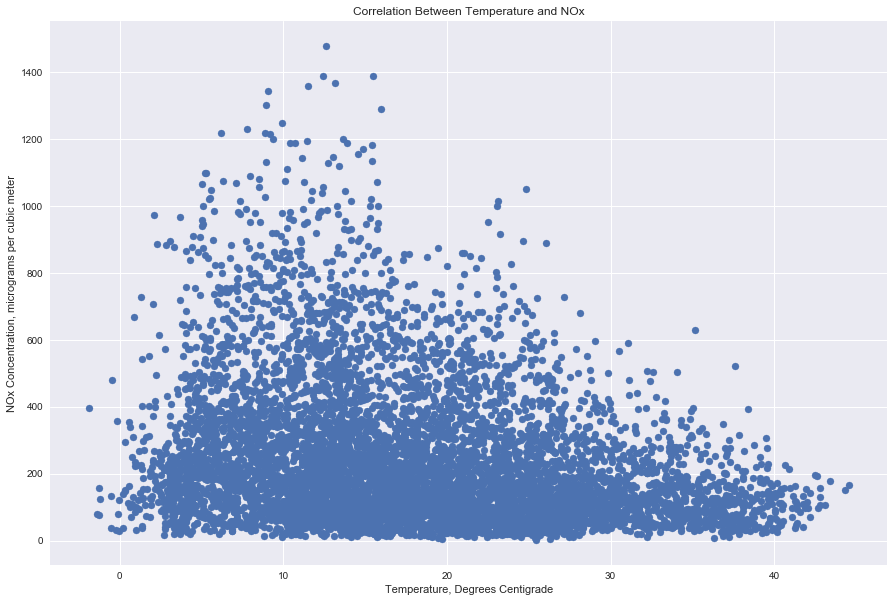

In [14]:
f, ax = plt.subplots(figsize = (15, 10))
plt.scatter(x = data1['T'], y = data1['NOx(GT)'])
ax.set_xlabel("Temperature, Degrees Centigrade")
ax.set_ylabel("NOx Concentration, micrograms per cubic meter")
ax.set_title("Correlation Between Temperature and NOx")
plt.show()

# (2) DataReader

We now read data from the St. Louis Federal Reserve website. Below, we include several monthly indicators of economic health, such as indices of inflation and production, as well as monetary measures. By examining data from the beginning of the year 2000, we can note trends in the United States economy and find which indicators are likely to move together.

We begin by reading in the data from the [FRED](https://fred.stlouisfed.org) website:

In [15]:
start = datetime(2000, 1, 1)
end = datetime(2017, 1, 1)

data2 = web.DataReader(["CPIAUCSL", "INDPRO","UNRATE", "M2SL", "M1SL","PAYEMS"], "fred", start, end)
data2.columns = ['CPI' , 'Industrial Production' , 'Unemployment', 'M2 Stock', 'M1 Stock', 'Non-Farm Payroll']

We now use the head() and info() functions to ensure that the data is organized correctly, and that each column includes the variables it should, in their correct formats.

In [16]:
data2.head()

,CPI,Industrial Production,Unemployment,M2 Stock,M1 Stock,Non-Farm Payroll
DATE,,,,,,
2000-01-01,169.3,94.5458,4.0,4656.3,1122.2,131009
2000-02-01,170.0,94.8185,4.1,4669.6,1108.6,131140
2000-03-01,171.0,95.1983,4.0,4700.4,1107.5,131608
2000-04-01,170.9,95.8921,3.8,4756.2,1115.6,131895
2000-05-01,171.2,96.0691,4.0,4743.7,1105.0,132121


In [17]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205 entries, 2000-01-01 to 2017-01-01
Freq: MS
Data columns (total 6 columns):
CPI                      205 non-null float64
Industrial Production    205 non-null float64
Unemployment             205 non-null float64
M2 Stock                 205 non-null float64
M1 Stock                 205 non-null float64
Non-Farm Payroll         205 non-null int64
dtypes: float64(5), int64(1)
memory usage: 11.2 KB


Everything seems to be in order. We proceed to plot out trends in each measurement over time, with the indices in the first graph, monetary base values in the second. We note that the CPI and Industrial Production indices exhibit similar trends, although the CPI has relatively smaller shocks than does the Industrial Production index. M1 and M2 are naturally similar in trend, as M2 includes M1 in its calculation.  The widening gap between the two, however, indicates that more money is being kept in savings and other time deposits.

Non-Farm Payroll, and the unemployment rate, are notable because their trends mirror each other - unsurprising, since wages are likely to decrease as unemployment increases.  Almost every graph shows a noticeable shift around the beginning of the 2009 recession, although the monetary base graph shows only a slight change.

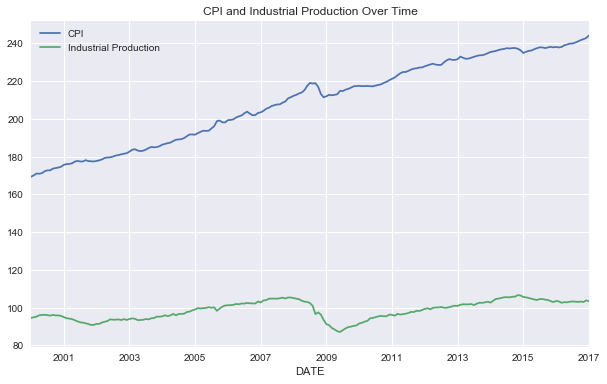

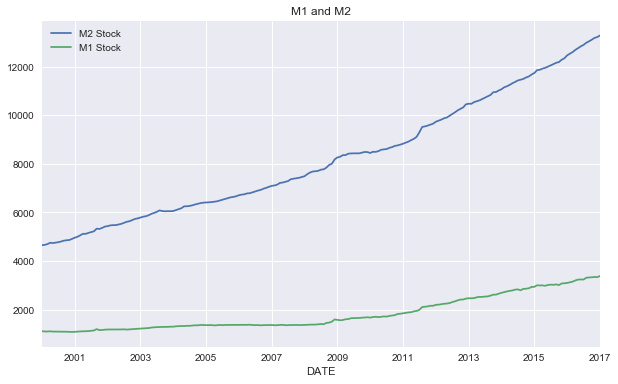

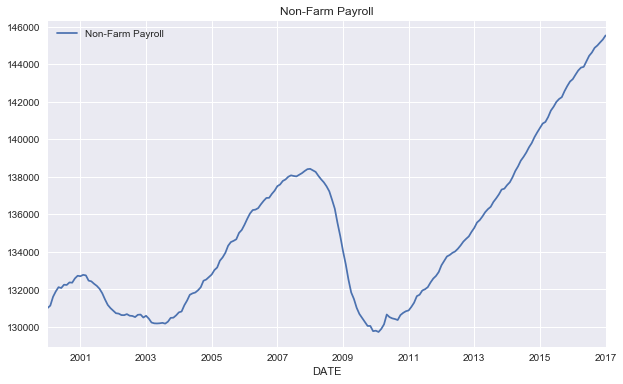

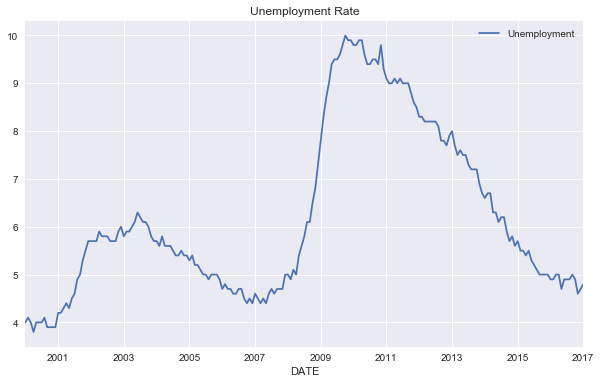

In [18]:
# sns.tsplot(data = data2, time = "DATE")
# look it up in matplotlib

data2 = data2.reset_index()
f, ax = plt.subplots(figsize = (10, 6))
ax.set_title("CPI and Industrial Production Over Time")
data2.plot.line("DATE", ['CPI' , 'Industrial Production'], ax = ax)
plt.show()

f, ax = plt.subplots(figsize = (10, 6))
ax.set_title("M1 and M2")
data2.plot.line("DATE", ['M2 Stock', 'M1 Stock'], ax = ax)
plt.show()

f, ax = plt.subplots(figsize = (10, 6))
ax.set_title("Non-Farm Payroll")
data2.plot.line("DATE", ['Non-Farm Payroll'], ax = ax)
plt.show()

f, ax = plt.subplots(figsize = (10, 6))
ax.set_title("Unemployment Rate")
data2.plot.line("DATE", ['Unemployment'], ax = ax)
plt.show()

We see that there is no missing data, which is beneficial to our analysis. Summary statistics since 2000 appear here.  Since some of these increase with time, they are less interesting; however, unemployment data over this period is the most informative column. The average unemployment rate is clearly skewed upward by the Great Recession, as the median rate is about 0.5% lower.

In [19]:
data2.describe()

,CPI,Industrial Production,Unemployment,M2 Stock,M1 Stock,Non-Farm Payroll
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,209.302098,98.523007,6.210732,8230.094146,1828.701951,134865.682927
std,22.443129,4.855684,1.753926,2450.179732,695.420050,4187.107368
min,169.300000,87.065000,3.800000,4656.300000,1088.600000,129733.000000
25%,187.400000,94.505600,4.900000,6177.100000,1332.900000,131176.000000
50%,212.709000,99.067400,5.700000,7760.300000,1406.700000,133758.000000
75%,231.221000,102.917900,7.500000,10260.900000,2421.700000,137710.000000
max,244.158000,106.613400,10.000000,13277.100000,3390.700000,145541.000000


We examine the correlations between these different economic variables in the table below:

In [20]:
data2.corr()

,CPI,Industrial Production,Unemployment,M2 Stock,M1 Stock,Non-Farm Payroll
CPI,1.000000,0.582100,0.406672,0.965117,0.893481,0.659238
Industrial Production,0.582100,1.000000,-0.380999,0.571838,0.573891,0.831624
Unemployment,0.406672,-0.380999,1.000000,0.290746,0.172299,-0.399987
M2 Stock,0.965117,0.571838,0.290746,1.000000,0.976548,0.724046
M1 Stock,0.893481,0.573891,0.172299,0.976548,1.000000,0.737437
Non-Farm Payroll,0.659238,0.831624,-0.399987,0.724046,0.737437,1.000000


As an alternate method of examining this data, we use a pairwise plot to visualize the correlation between several of these variables. Although some trends may appear in the table above, it is worth noting that few clear relationships exist. For example, unemployment is negatively correlated with the Industrial Production Index, but as seen below, there is hardly a clear relationship between the two - in fact, employment between 4 and 6 percent can occur whether the Industrial Production Index is high or low.

A few notable exceptions exist - M1 and M2, both being measures of the money supply, are very strongly correlated. They are also related to the CPI, a measure of inflation.  This supports macroeconomic theory linking the money supply and the inflation rate.

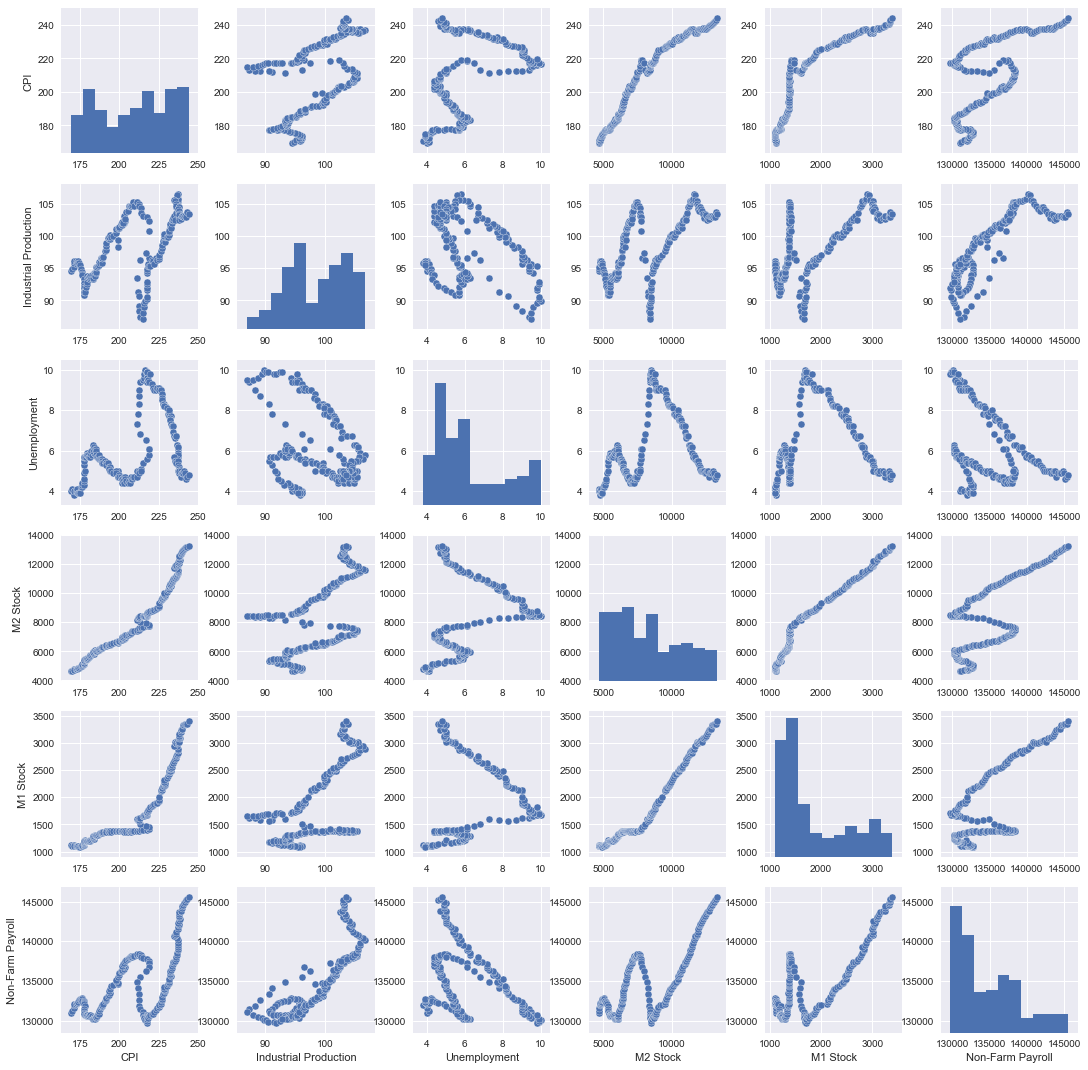

In [21]:
g = sns.pairplot(data2)

# (3) JSON

This final dataset shows hotel occupancy data in Arlington, Virginia - a suburb of the Washington D.C. area and the county next to my own. This data may show either a steady flow of visitors, a plausible expectation for hotels near a big city, or perhaps a seasonal fluctuation driven by political events and tourists (such as an inauguration, school breaks, and Congressional recess). We proceed to examine these trends, and begin by loading in our data:


In [22]:
get_request = requests.get("https://api.data.arlingtonva.us/api/v2/datastreams/CURRE-HOTEL-OCCUP/data.json?auth_key=3853456938efc09269c3d1d2fd12726ca2e11f36")

In [23]:
get_request.text

'{"result":{"fLength":5,"fType":"ARRAY","fTimestamp":1513870568962,"fArray":[{"fStr":"","fHeader":true,"fType":"TEXT"},{"fStr":"Jan","fHeader":true,"fType":"TEXT"},{"fStr":"Feb","fHeader":true,"fType":"TEXT"},{"fStr":"Mar","fHeader":true,"fType":"TEXT"},{"fStr":"Apr","fHeader":true,"fType":"TEXT"},{"fStr":"May","fHeader":true,"fType":"TEXT"},{"fStr":"Jun","fHeader":true,"fType":"TEXT"},{"fStr":"Jul","fHeader":true,"fType":"TEXT"},{"fStr":"Aug","fHeader":true,"fType":"TEXT"},{"fStr":"Sep","fHeader":true,"fType":"TEXT"},{"fStr":"Oct","fHeader":true,"fType":"TEXT"},{"fStr":"Nov","fHeader":true,"fType":"TEXT"},{"fStr":"Dec","fHeader":true,"fType":"TEXT"},{"fStr":"2017","fType":"TEXT"},{"fStr":"62.2%","fType":"TEXT"},{"fStr":"69.4%","fType":"TEXT"},{"fStr":"85.1%","fType":"TEXT"},{"fStr":"89.2%","fType":"TEXT"},{"fStr":"86.7%","fType":"TEXT"},{"fStr":"86.0%","fType":"TEXT"},{"fStr":"84.9%","fType":"TEXT"},{"fStr":"75.4%","fType":"TEXT"},{"fStr":"75.9%","fType":"TEXT"},{"fStr":"83.1%","fType

This is difficult to analyze in its present state. To begin to sort this information into a dataframe, we load in the data dictionary and find the keys, which will be used to select only the data of interest.

In [24]:
data_dict = json.loads(get_request.text)

In [25]:
data_dict.keys()

dict_keys(['result', 'description', 'parameters', 'tags', 'timestamp', 'created_at', 'title', 'modified_at', 'category_id', 'sources', 'frequency', 'link', 'user', 'guid', 'category_name'])

Now that our data has been entered, we can use the data dictionary to find the actual data:

In [26]:
df3 = pd.DataFrame(data_dict['result'])

We may need to continue cleaning the data. To better understand the format of this JSON, we will view the dataframe we have previously constructed and thereby determine the best way to retrieve the data:

In [27]:
df3.head()

,fArray,fCols,fLength,fRows,fTimestamp,fType
0,"{'fStr': '', 'fHeader': True, 'fType': 'TEXT'}",13,5,5,1513870568962,ARRAY
1,"{'fStr': 'Jan', 'fHeader': True, 'fType': 'TEXT'}",13,5,5,1513870568962,ARRAY
2,"{'fStr': 'Feb', 'fHeader': True, 'fType': 'TEXT'}",13,5,5,1513870568962,ARRAY
3,"{'fStr': 'Mar', 'fHeader': True, 'fType': 'TEXT'}",13,5,5,1513870568962,ARRAY
4,"{'fStr': 'Apr', 'fHeader': True, 'fType': 'TEXT'}",13,5,5,1513870568962,ARRAY


A loop seems to be the most effective way. We begin with the construction of an empty dataframe, into which we will load the corresponding values from the JSON.

In [28]:
data3 = pd.DataFrame(columns = range(0,5), index = (0,13))

In [29]:
for column in range(0,5):
    for row in range(0,13):
        data3.loc[row,column] = data_dict['result']['fArray'][13*column + row]['fStr']

In [30]:
display(data3)

,0,1,2,3,4
0,,2017,2016,2015,2014
13,NaN,NaN,NaN,NaN,NaN
1,Jan,62.2%,54.5%,58.2%,54.6%
2,Feb,69.4%,70.9%,68.2%,67.1%
3,Mar,85.1%,87.3%,82.8%,80.3%
4,Apr,89.2%,89.2%,90.2%,88.2%
5,May,86.7%,86.9%,85.7%,85.4%
6,Jun,86.0%,87.7%,87.5%,84.8%
7,Jul,84.9%,85.3%,86.2%,85.8%
8,Aug,75.4%,75.6%,76.5%,76.5%


In [31]:
data3.columns = ['Month', '2017', '2016', '2015', '2014']
data3 = data3.drop(0,0)
data3 = data3.drop(13, 0)
display(data3)

,Month,2017,2016,2015,2014
1,Jan,62.2%,54.5%,58.2%,54.6%
2,Feb,69.4%,70.9%,68.2%,67.1%
3,Mar,85.1%,87.3%,82.8%,80.3%
4,Apr,89.2%,89.2%,90.2%,88.2%
5,May,86.7%,86.9%,85.7%,85.4%
6,Jun,86.0%,87.7%,87.5%,84.8%
7,Jul,84.9%,85.3%,86.2%,85.8%
8,Aug,75.4%,75.6%,76.5%,76.5%
9,Sep,75.9%,80.4%,78.0%,79.0%
10,Oct,83.1%,82.9%,84.7%,82.2%


The data appears to be correct - however, there are blank values for November and December, 2017. Since these occupancy columns are currently string objects, we temporarily fill this blank with a missing item code that will convert easily to a float with the rest of the data. Below, we ensure the change has been made as desired.

In [32]:
data3.loc[11, '2017'] = "-200"
data3.loc[12, '2017'] = "-200"

In [33]:
display(data3)

,Month,2017,2016,2015,2014
1,Jan,62.2%,54.5%,58.2%,54.6%
2,Feb,69.4%,70.9%,68.2%,67.1%
3,Mar,85.1%,87.3%,82.8%,80.3%
4,Apr,89.2%,89.2%,90.2%,88.2%
5,May,86.7%,86.9%,85.7%,85.4%
6,Jun,86.0%,87.7%,87.5%,84.8%
7,Jul,84.9%,85.3%,86.2%,85.8%
8,Aug,75.4%,75.6%,76.5%,76.5%
9,Sep,75.9%,80.4%,78.0%,79.0%
10,Oct,83.1%,82.9%,84.7%,82.2%


In [34]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 1 to 12
Data columns (total 5 columns):
Month    12 non-null object
2017     12 non-null object
2016     12 non-null object
2015     12 non-null object
2014     12 non-null object
dtypes: object(5)
memory usage: 896.0+ bytes


As can be seen above, we have percentage data that is currently in string form. Below, we adjust each column and drop the data we have already coded as missing. Using the head() command, we note that at least some formatting changes have been implemented. The info() command that follows reassures us that our data is now in float form, which can be used for visualization and analysis.

In [35]:
data3['2017'] = data3['2017'].str.replace('%', '')
data3['2017'] = data3['2017'].astype(float)
data3['2016'] = data3['2016'].str.replace('%', '')
data3['2016'] = data3['2016'].astype(float)
data3['2015'] = data3['2015'].str.replace('%', '')
data3['2015'] = data3['2015'].astype(float)
data3['2014'] = data3['2014'].str.replace('%', '')
data3['2014'] = data3['2014'].astype(float)

data3 = data3.replace(-200, np.NaN)

data3.head()
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 1 to 12
Data columns (total 5 columns):
Month    12 non-null object
2017     10 non-null float64
2016     12 non-null float64
2015     12 non-null float64
2014     12 non-null float64
dtypes: float64(4), object(1)
memory usage: 896.0+ bytes


We will now begin exploring the data itself. With a descriptive table, we can see a few statistics of interest. 

In [36]:
data3.describe()

,2017,2016,2015,2014
count,10.000000,12.000000,12.000000,12.000000
mean,79.790000,77.208333,76.866667,75.916667
std,8.767928,12.126939,11.767701,11.342104
min,62.200000,54.500000,54.600000,54.600000
25%,75.525000,70.600000,69.400000,69.500000
50%,84.000000,81.650000,80.400000,79.650000
75%,85.775000,87.000000,85.825000,84.950000
max,89.200000,89.200000,90.200000,88.200000


We begin with a simple line graph that shows monthly variation in occupancy rates for the years and months included in the dataset.

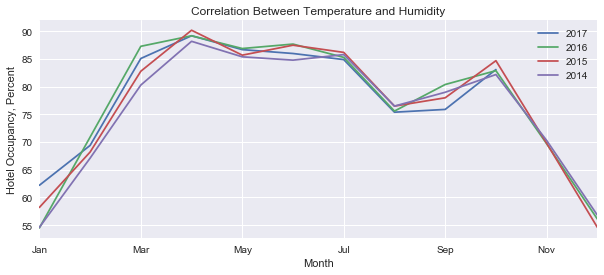

In [37]:
f, ax = plt.subplots(figsize = (10, 4))

ax.set_ylabel("Hotel Occupancy, Percent")
ax.set_xlabel("Months")
ax.set_title("Correlation Between Temperature and Humidity")
data3.plot.line("Month", ['2017', '2016', '2015', '2014'], ax = ax)
plt.show()

These rates appear to be fairly consistent, which must be beneficial for hotel managers in setting prices. We note that for winter months, occupancy typically dips to around 55% or 60%, while peak months in the spring and early summer have nearly 90% occupancy.  There is also a notable dip in August, when the United States Congress has recess. Fewer meetings are held, meaning lobbyists and others would be expected to travel less. However, being a summer month, visitors must keep hotels busier than during the brief recess in the end of December.

It is difficult to see any yearly trend in occupancy. It seems that average monthly attendance may increase slightly over the years, with 2017's levels dropping again toward the end of the year. January 2017 saw markedly increased levels compared to other years, which may be due to visitors for the presidential inauguration and associated events.

Below, we see how each year's monthly average compares to the others. Since we only have data for 2017, we use the first 10 months of each year to be consistent. We do this rather than computing each year's occupancy data divided by the number of months for which data is available, as November and December seem to be less busy; their ommission would skew 2017's average upward.

We create a table of these average values:

In [38]:
data3_avg = data3
data3_avg = data3_avg.drop(11,0)
data3_avg = data3_avg.drop(12,0)
data3_avg['Month'] = "Avg"
data3_avg = data3_avg.groupby(data3_avg['Month']).sum() / 10
data3_avg.reset_index(level=0, inplace=True)
display(data3_avg)

,Month,2017,2016,2015,2014
0,Avg,79.79,80.07,79.8,78.39


To plot this data, we will transpose the dataframe and rename the columns:

In [39]:
data3_avg = data3_avg.transpose()
data3_avg.reset_index(level=0, inplace=True)
data3_avg.columns = ['Year', 'Average Montly Occupancy, Percent']
data3_avg = data3_avg.drop(0,0)
display(data3_avg)

,Year,"Average Montly Occupancy, Percent"
1,2017,79.79
2,2016,80.07
3,2015,79.8
4,2014,78.39


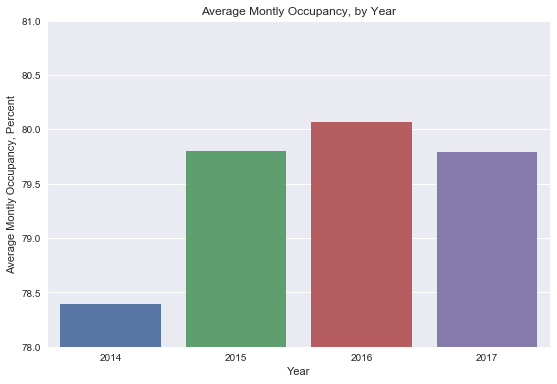

In [40]:
low = min(data3_avg['Average Montly Occupancy, Percent'])
high = max(data3_avg['Average Montly Occupancy, Percent'])
f, ax = plt.subplots(figsize=(9, 6))
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
ax.set_title("Average Montly Occupancy, by Year")
sns.barplot(data3_avg['Year'], data3_avg['Average Montly Occupancy, Percent'], ax = ax)

Apparently, the first 10 months in 2017 saw an average lower hotel occupancy than the previous year, a break in the increasing trend from 2014-2016. Additionally, the difference between each year's average is not as pronounced as it might seem - the scaling on the y-axis is only 0.5% per line, so the difference in average monthly occupancy is no more than 2% between the years displayed.